In [1]:
#Import the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report

In [2]:
# Load the dataset
file_path = "Spotify Data.csv"
sdata = pd.read_csv(file_path)

# Display basic information about the dataset
df_info = sdata.info()
df_head = sdata.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

(None,
                  track_id                 artists  \
 0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
 1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
 2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
 3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
 4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
 
                                           album_name  \
 0                                             Comedy   
 1                                   Ghost (Acoustic)   
 2                                     To Begin Again   
 3  Crazy Rich Asians (Original Motion Picture Sou...   
 4                                            Hold On   
 
                    track_name  popularity  duration_ms  explicit  \
 0                      Comedy          73       230666     False   
 1            Ghost - Acoustic          55       149610     False   
 2              To Begin Again          57       210826     False   
 3  Can't Help Falling In Love          71     

In [3]:
# 1. Standardizing simple text columns, not names (strip spaces, lowercase)
sdata['track_genre'] = sdata['track_genre'].str.strip().str.lower()

#2. Convert popularity to binary labels (1 = Popular, 0 = Not Popular)
sdata["popularity_label"] = (sdata["popularity"] > 80).astype(int)

#3 Handle missing values (drop rows with missing artist, album_name, or track_name)
sdata = sdata.dropna()

#4. Normalize loudness (since it's in negative decibels)
sdata["loudness"] = (sdata["loudness"] - sdata["loudness"].min()) / (sdata["loudness"].max() - sdata["loudness"].min())

#5. Normalize tempo
sdata["tempo"] = (sdata["tempo"] - sdata["tempo"].min()) / (sdata["tempo"].max() - sdata["tempo"].min())

#6. Drop track_id
sdata = sdata.drop(columns=["track_id"])  

#7. Remove duplicates
sdata_clean = sdata.drop_duplicates()

#8. Confirm dataset cleanup
print(sdata_clean.info())
print(sdata_clean.head())



<class 'pandas.core.frame.DataFrame'>
Index: 113422 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113422 non-null  object 
 1   album_name        113422 non-null  object 
 2   track_name        113422 non-null  object 
 3   popularity        113422 non-null  int64  
 4   duration_ms       113422 non-null  int64  
 5   explicit          113422 non-null  bool   
 6   danceability      113422 non-null  float64
 7   energy            113422 non-null  float64
 8   key               113422 non-null  int64  
 9   loudness          113422 non-null  float64
 10  mode              113422 non-null  int64  
 11  speechiness       113422 non-null  float64
 12  acousticness      113422 non-null  float64
 13  instrumentalness  113422 non-null  float64
 14  liveness          113422 non-null  float64
 15  valence           113422 non-null  float64
 16  tempo             113422 

In [4]:
# Features to analyze 
features = ["danceability", "energy", "valence", "loudness", "acousticness", "tempo"]

# Finding Min and Max for each feature
high_low_values = {}
for feature in features:
    high_low_values[feature] = {
        "Minimum": sdata_clean[feature].min(),
        "Maximum": sdata_clean[feature].max()
    }

# Convert to DataFrame for better readability
high_low_df = pd.DataFrame(high_low_values)

# Display the results
print(high_low_df)


         danceability  energy  valence  loudness  acousticness  tempo
Minimum         0.000     0.0    0.000       0.0         0.000    0.0
Maximum         0.985     1.0    0.995       1.0         0.996    1.0


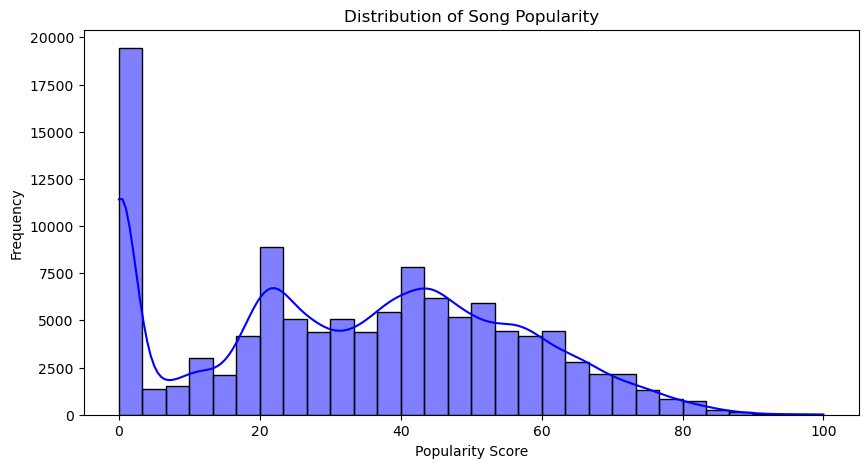

In [5]:
# Plot distribution of popularity scores to show how many are 
plt.figure(figsize=(10, 5))
sns.histplot(sdata_clean["popularity"], bins=30, kde=True, color="blue")
plt.title("Distribution of Song Popularity")
plt.xlabel("Popularity Score")
plt.ylabel("Frequency")
plt.show()

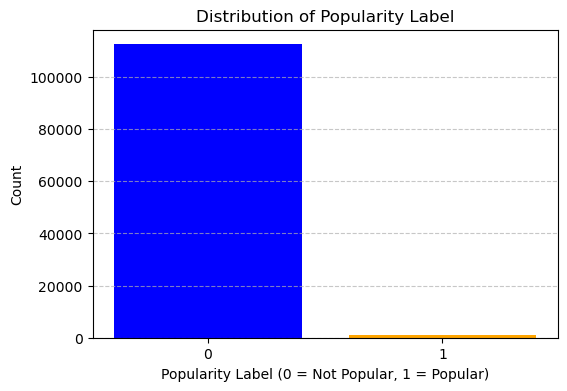

In [6]:
# Since 'popularity_code' is a binary variable (0 or 1)
if 'popularity_label' in sdata_clean.columns:
    # Count occurrences of each category (0 and 1)
    popularity_counts = sdata_clean['popularity_label'].value_counts()

    # Create bar plot
    plt.figure(figsize=(6, 4))
    plt.bar(popularity_counts.index.astype(str), popularity_counts.values, color=['blue', 'orange'])
    plt.xlabel("Popularity Label (0 = Not Popular, 1 = Popular)")
    plt.ylabel("Count")
    plt.title("Distribution of Popularity Label")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Column 'popularity_label' not found in the dataset. Please ensure it exists.")


In [7]:
# Drop non-numeric and unnecessary columns
sdata.drop(columns=["track_id", "artists", "album_name", "track_name", "track_genre", "explicit"], inplace=True, errors='ignore')

# Convert popularity into numeric binary values
sdata["popularity_label"] = (sdata["popularity"] > 80).astype(int)

# Define Features (X) and Target (y)
X = sdata.drop(columns=["popularity_label", "popularity"])  # Drop target variable and raw popularity
y = sdata["popularity_label"]

# Ensure all columns in X are numeric
print(X.dtypes)  # Check that all remaining features are numerical

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42, sampling_strategy=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
sdata_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=["popularity_label"])], axis=1)

# Check new class balance
sdata_balanced.info()
print("Balanced Class Distribution:")
print(sdata_balanced["popularity_label"].value_counts())

duration_ms           int64
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226090 entries, 0 to 226089
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       226090 non-null  int64  
 1   danceability      226090 non-null  float64
 2   energy            226090 non-null  float64
 3   key               226090 non-null  int64  
 4   loudness          226090 non-null  float64
 5   mode              226090 non-null  int64  
 6   speechiness       226090 non-null  float64
 7   acousticness      226090 non-null  float64
 8   instrumentalness  226090 n

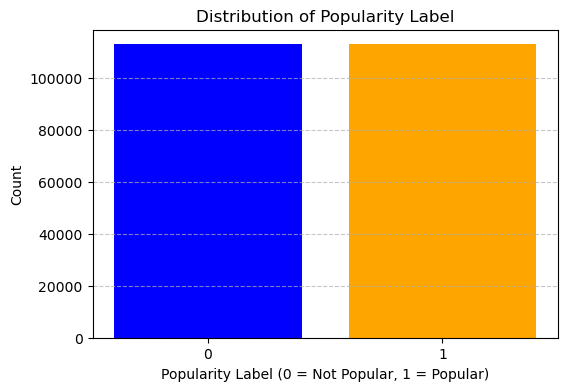

In [8]:
# Re-examine the distribution after balancing
if 'popularity_label' in sdata_balanced.columns:
    # Count occurrences of each category (0 and 1)
    popularity_counts = sdata_balanced['popularity_label'].value_counts()

    # Create bar plot
    plt.figure(figsize=(6, 4))
    plt.bar(popularity_counts.index.astype(str), popularity_counts.values, color=['blue', 'orange'])
    plt.xlabel("Popularity Label (0 = Not Popular, 1 = Popular)")
    plt.ylabel("Count")
    plt.title("Distribution of Popularity Label")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Column 'popularity_label' not found in the dataset. Please ensure it exists.")


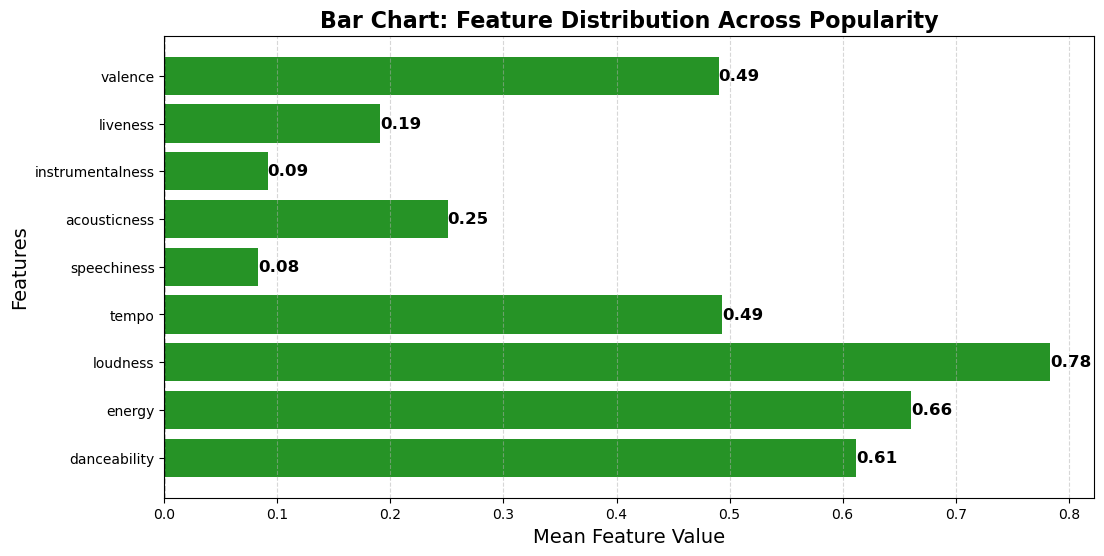

In [11]:
# Selecting numerical features for visualization
numerical_features = ['danceability', 'energy', 'loudness', 'tempo', 'speechiness',
                      'acousticness', 'instrumentalness', 'liveness', 'valence',]

# Compute the average of each feature across popularity labels (without additional normalization)
diverging_data = sdata_balanced.groupby('popularity_label')[numerical_features].mean().mean()

# Define color mapping (green for positive, red for negative)
colors = ['red' if value < 0 else 'green' for value in diverging_data]

# Create a diverging bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(diverging_data.index, diverging_data.values, color=colors, alpha=0.85)

# Add annotations
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', 
             va='center', ha='left' if bar.get_width() > 0 else 'right',
             fontsize=12, fontweight='bold')

# Styling
plt.axvline(0, color='black', linestyle='--', linewidth=1)  
plt.xlabel("Mean Feature Value", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Bar Chart: Feature Distribution Across Popularity", fontsize=16, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

In [12]:
# Compute numerical statistics and print the stats as a chart
numerical_stats = sdata_balanced[numerical_features].describe().round(2)

numerical_stats

,danceability,energy,loudness,tempo,speechiness,acousticness,instrumentalness,liveness,valence
count,226090.00,226090.00,226090.00,226090.00,226090.00,226090.00,226090.00,226090.00,226090.00
mean,0.61,0.66,0.78,0.49,0.08,0.25,0.09,0.19,0.49
std,0.16,0.21,0.08,0.11,0.09,0.28,0.24,0.16,0.24
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.52,0.54,0.76,0.41,0.04,0.03,0.00,0.10,0.30
50%,0.63,0.69,0.80,0.49,0.05,0.13,0.00,0.13,0.48
75%,0.73,0.81,0.83,0.56,0.09,0.40,0.00,0.23,0.67
max,0.98,1.00,1.00,1.00,0.96,1.00,1.00,1.00,1.00


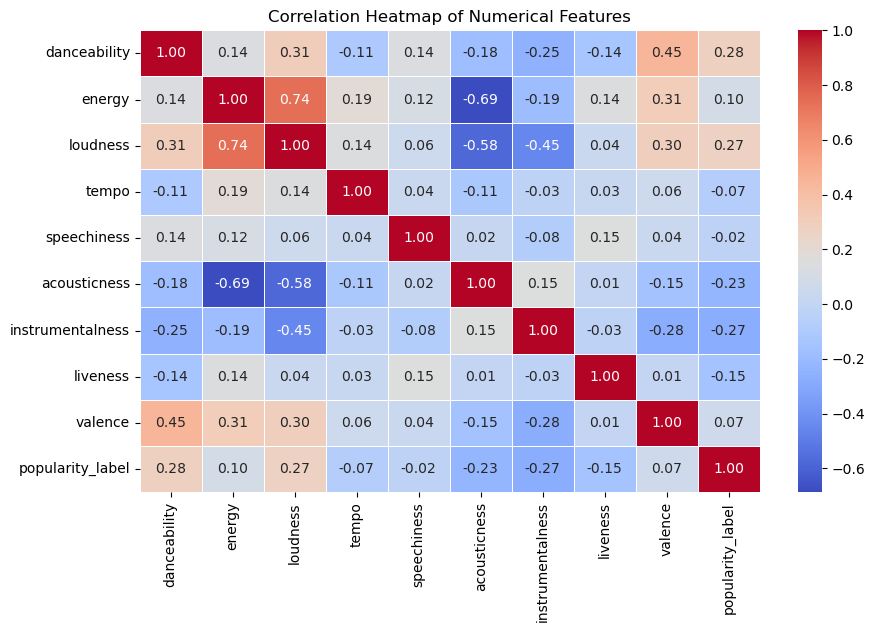

In [13]:
# Compute correlation with popularity_label
correlation_matrix = sdata_balanced[numerical_features + ['popularity_label']].corr()
feature_correlations = correlation_matrix["popularity_label"].abs().drop("popularity_label")  # Absolute correlation values

# Plot Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

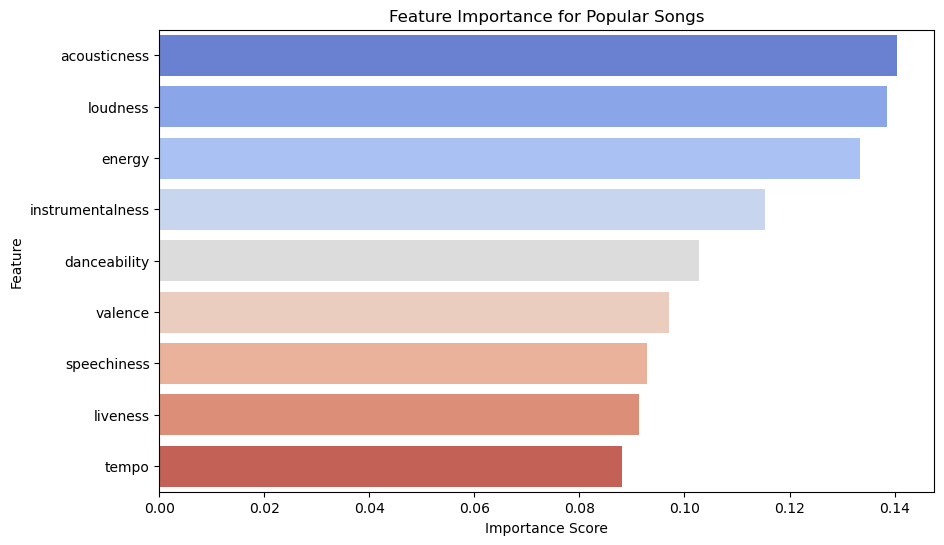

In [17]:
# Ensure numerical_features is a list of valid column names
if not isinstance(numerical_features, list):
    raise TypeError("numerical_features should be a list of column names.")

# Extract selected numerical columns from DataFrame
X_popular = sdata_balanced[numerical_features]  
X_popular = X_popular.select_dtypes(include=[np.number])  # Keep only numeric columns
X_popular = X_popular.fillna(X_popular.mean())  # Handle missing values
y_popular = sdata_balanced['popularity_label']

# Train RandomForest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_popular, y_popular)

# Feature importance DataFrame
importance_df = pd.DataFrame({'Feature': X_popular.columns, 'Importance': rf_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, legend=False, palette='coolwarm')
plt.title('Feature Importance for Popular Songs')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


In [14]:
# Convert popularity_label to int
sdata_balanced["popularity_label"] = sdata_balanced["popularity_label"].astype(int)

# Create separate datasets for popularity_label = 1 and popularity_label = 0
popularity_label_Y = sdata_balanced[sdata_balanced["popularity_label"] == 1]
popularity_label_N = sdata_balanced[sdata_balanced["popularity_label"] == 0]

# Print dataset sizes to verify
print(f"🔹 Popular Songs (popularity_label = 1): {popularity_label_Y.shape[0]} rows")
print(f"🔹 Unpopular Songs (popularity_label = 0): {popularity_label_N.shape[0]} rows")

🔹 Popular Songs (popularity_label = 1): 113045 rows
🔹 Unpopular Songs (popularity_label = 0): 113045 rows



 Correlation Matrix:

                  danceability    energy  loudness     tempo  speechiness  \
danceability          1.000000  0.074783  0.242738 -0.156287     0.251059   
energy                0.074783  1.000000  0.694564  0.109537     0.047886   
loudness              0.242738  0.694564  1.000000  0.078844     0.107136   
tempo                -0.156287  0.109537  0.078844  1.000000     0.086491   
speechiness           0.251059  0.047886  0.107136  0.086491     1.000000   
acousticness         -0.024425 -0.546105 -0.437296  0.012624     0.056574   
instrumentalness     -0.276687 -0.122383 -0.263426 -0.053436    -0.097596   
liveness             -0.037420  0.082918  0.119182  0.065063    -0.007607   
valence               0.406049  0.421172  0.341472  0.051657     0.059895   

                  acousticness  instrumentalness  liveness   valence  
danceability         -0.024425         -0.276687 -0.037420  0.406049  
energy               -0.546105         -0.122383  0.082918  0.42

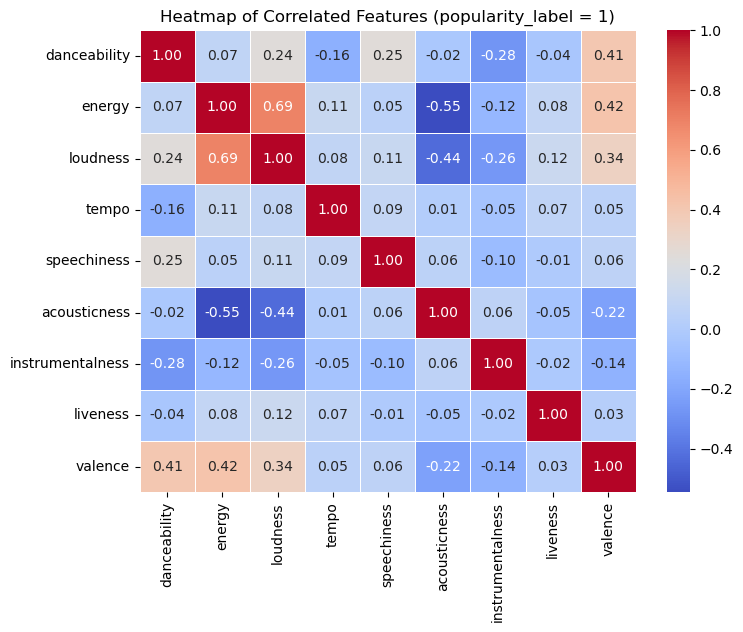

In [20]:
# Selecting numerical features within the popularity_label_Y frame
numerical_features = ['danceability', 'energy', 'loudness', 'tempo', 'speechiness',
                      'acousticness', 'instrumentalness', 'liveness', 'valence']

# Compute correlation matrix within `popularity_label_Y`
corr_matrix_Y = popularity_label_Y[numerical_features].corr()

#Print correlation scores
print("\n Correlation Matrix:\n")
print(corr_matrix_Y)

# Plot Heatmap for `popularity_label_Y`
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_Y, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Correlated Features (popularity_label = 1)")
plt.show()


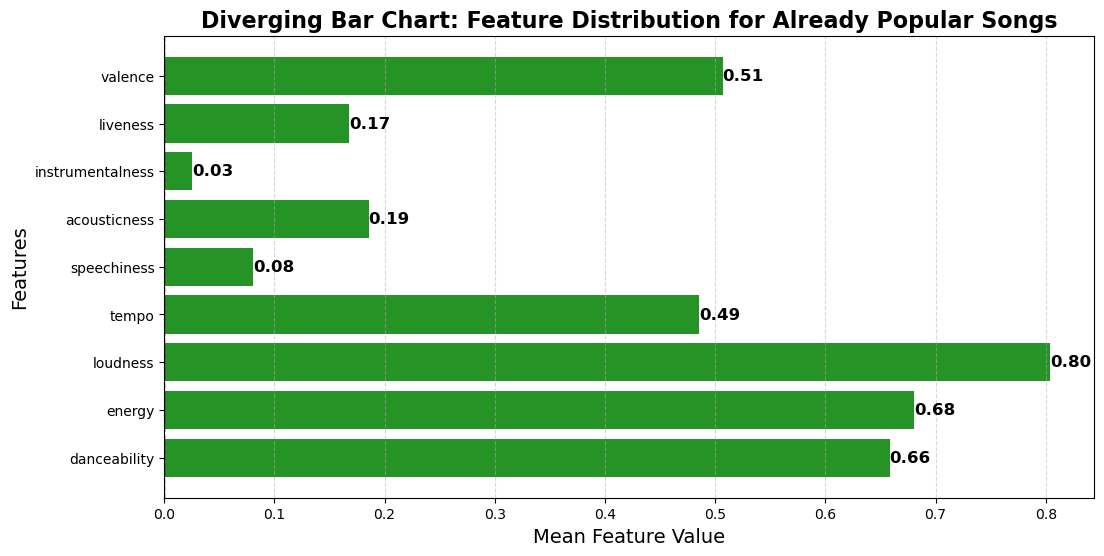

In [21]:
# Compute the mean of each feature for popular songs
diverging_data_Y = popularity_label_Y[numerical_features].mean()

# Define color mapping (green for positive, red for negative)
colors = ['red' if value < 0 else 'green' for value in diverging_data_Y]

# Create a diverging bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(diverging_data_Y.index, diverging_data_Y.values, color=colors, alpha=0.85)

# Add annotations
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', 
             va='center', ha='left' if bar.get_width() > 0 else 'right',
             fontsize=12, fontweight='bold')

# Styling
plt.axvline(0, color='black', linestyle='--', linewidth=1)  
plt.xlabel("Mean Feature Value", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Diverging Bar Chart: Feature Distribution for Already Popular Songs", fontsize=16, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Show plot
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 113045 entries, 4 to 226089
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       113045 non-null  int64  
 1   danceability      113045 non-null  float64
 2   energy            113045 non-null  float64
 3   key               113045 non-null  int64  
 4   loudness          113045 non-null  float64
 5   mode              113045 non-null  int64  
 6   speechiness       113045 non-null  float64
 7   acousticness      113045 non-null  float64
 8   instrumentalness  113045 non-null  float64
 9   liveness          113045 non-null  float64
 10  valence           113045 non-null  float64
 11  tempo             113045 non-null  float64
 12  time_signature    113045 non-null  int64  
 13  popularity_label  113045 non-null  int32  
dtypes: float64(9), int32(1), int64(4)
memory usage: 12.5 MB
None


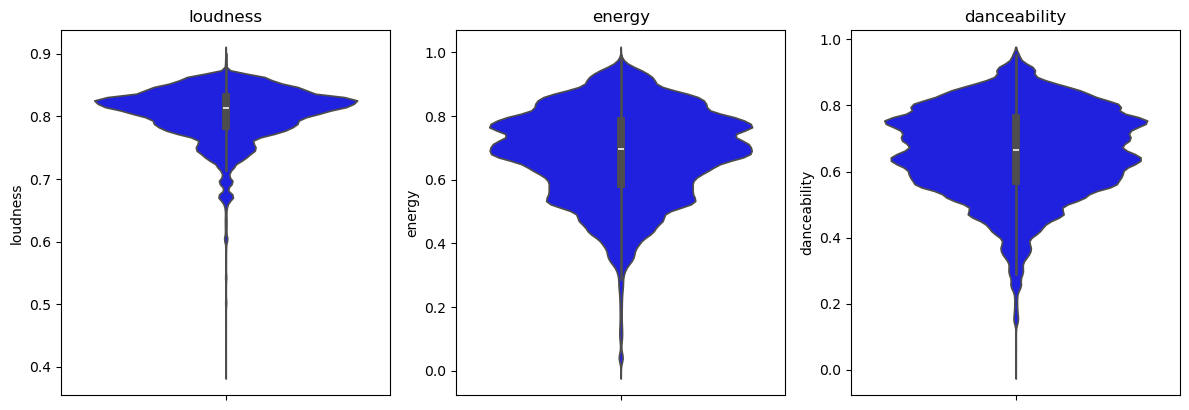

In [22]:
# Load dataset (assuming 'sdata_balanced' exists from previous processing)
popular_songs = sdata_balanced[sdata_balanced['popularity_label'] == 1]

print(popular_songs.info())

# Create a sub-set of key features with high correlation
key_feat = popular_songs[['loudness', 'energy', 'danceability']]

# 1. Feature Distribution - Violin Plots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_feat.columns):  # Iterating over selected key features
    plt.subplot(2, 3, i + 1)
    sns.violinplot(y=popular_songs[feature], color='blue')
    plt.title(feature)
plt.tight_layout()
plt.show()



# Splitting of the Data for Test/Training Sets

Logistic Regression Accuracy: 0.6721

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.62      0.65     22609
           1       0.66      0.72      0.69     22609

    accuracy                           0.67     45218
   macro avg       0.67      0.67      0.67     45218
weighted avg       0.67      0.67      0.67     45218



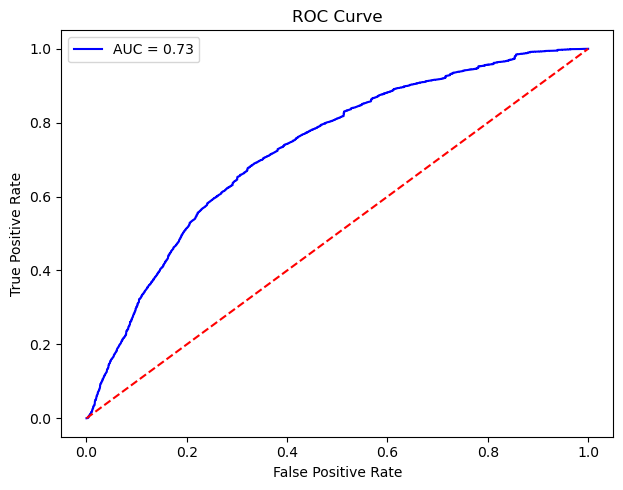

In [23]:
# Ensure key_feat is a valid list of column names
if isinstance(key_feat, pd.DataFrame):
    key_feat = list(key_feat.columns)  # Convert DataFrame to column list
elif not isinstance(key_feat, list):
    raise TypeError("key_feat should be a list of column names.")

# Extract numerical features from dataset
X = sdata_balanced[key_feat]
y = sdata_balanced['popularity_label']

# Handle missing values
X = X.fillna(X.mean())

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
Log_y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC curve

# Performance metrics
Log_accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {Log_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, Log_y_proba)
roc_auc = auc(fpr, tpr)

# --- PLOTS ---
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()


Decision Tree Accuracy: 0.7131
              precision    recall  f1-score   support

           0       0.84      0.53      0.65     22609
           1       0.66      0.90      0.76     22609

    accuracy                           0.71     45218
   macro avg       0.75      0.71      0.70     45218
weighted avg       0.75      0.71      0.70     45218


Random Forest Accuracy: 0.9342
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     22609
           1       0.92      0.95      0.93     22609

    accuracy                           0.93     45218
   macro avg       0.93      0.93      0.93     45218
weighted avg       0.93      0.93      0.93     45218


Gradient Boosting Accuracy: 0.7551
              precision    recall  f1-score   support

           0       0.79      0.70      0.74     22609
           1       0.73      0.81      0.77     22609

    accuracy                           0.76     45218
   macro avg       0.76     

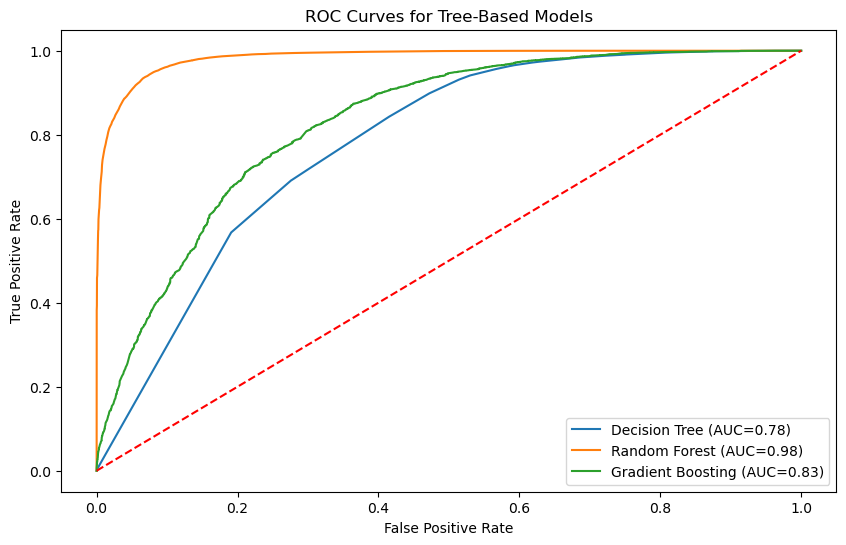

In [24]:
# Define tree-based models
Tree_models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Store results for comparison
Tree_model_results = {}
plt.figure(figsize=(10, 6))

for name, model in Tree_models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve
    
    # Accuracy and classification report
    Tree_accuracy = accuracy_score(y_test, y_pred)
    Tree_model_results[name] = {
        "Accuracy": Tree_accuracy,
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "y_proba": y_proba
    }
    print(f"\n{name} Accuracy: {Tree_accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")

# Finalize ROC Curve Plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Tree-Based Models")
plt.legend()
plt.show()



LDA Accuracy: 0.6673
              precision    recall  f1-score   support

           0       0.70      0.60      0.64     22609
           1       0.65      0.74      0.69     22609

    accuracy                           0.67     45218
   macro avg       0.67      0.67      0.67     45218
weighted avg       0.67      0.67      0.67     45218


QDA Accuracy: 0.6916
              precision    recall  f1-score   support

           0       0.78      0.53      0.63     22609
           1       0.64      0.85      0.73     22609

    accuracy                           0.69     45218
   macro avg       0.71      0.69      0.68     45218
weighted avg       0.71      0.69      0.68     45218



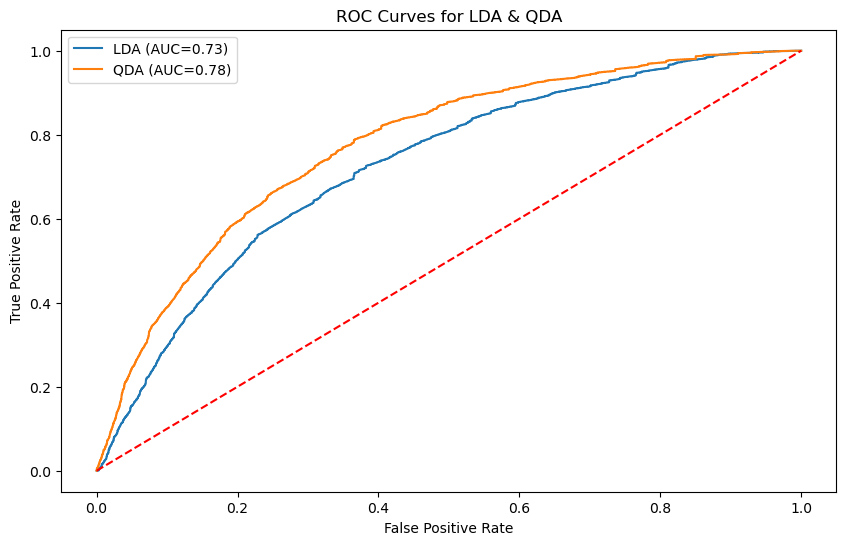

In [25]:
LDA_models = {
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis()
}

# Store results for comparison
LDA_model_results = {}
plt.figure(figsize=(10, 6))

for name, model in LDA_models.items():
    try:
        # Train the model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve
        
        # Accuracy and classification report
        LDA_accuracy = accuracy_score(y_test, y_pred)
        LDA_model_results[name] = {
        "Accuracy": LDA_accuracy,
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "y_proba": y_proba
    }
       
        print(f"\n{name} Accuracy: {LDA_accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.2f})")
    
    except Exception as e:
        print(f"⚠️ {name} failed: {e}")

# Finalize ROC Curve Plot
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for LDA & QDA")
plt.legend()
plt.show()


Neural Network Accuracy: 0.7544

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.68      0.74     22609
           1       0.72      0.83      0.77     22609

    accuracy                           0.75     45218
   macro avg       0.76      0.75      0.75     45218
weighted avg       0.76      0.75      0.75     45218



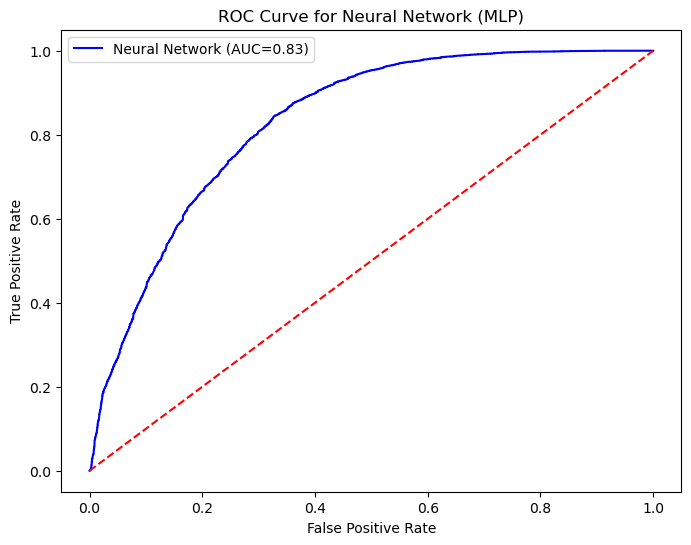

In [26]:
# Train a Neural Network (MLPClassifier)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = mlp_model.predict(X_test_scaled)
MLP_y_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC curve

# Performance metrics
MLP_accuracy = accuracy_score(y_test, y_pred)
print(f"Neural Network Accuracy: {MLP_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, MLP_y_proba)
roc_auc = auc(fpr, tpr)

# --- PLOT ROC CURVE ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Neural Network (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Neural Network (MLP)")
plt.legend()
plt.show()

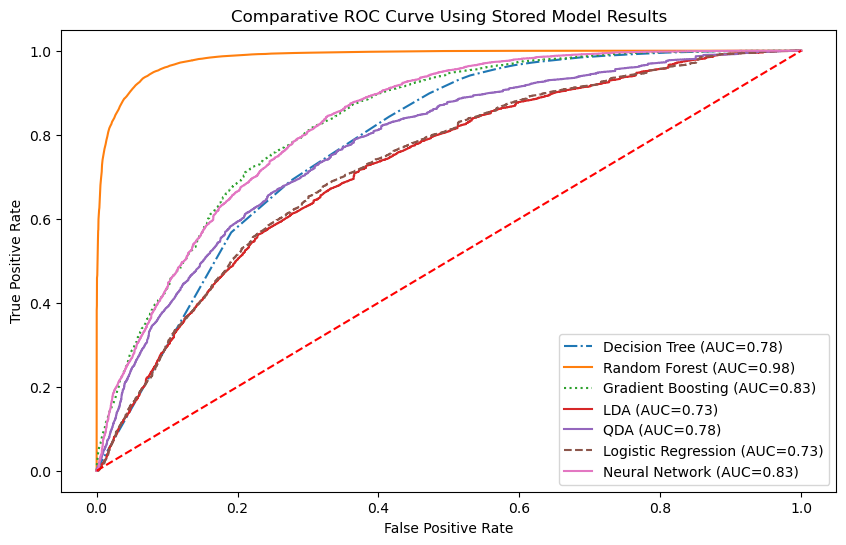

In [27]:
# Extract stored probability predictions correctly
fpr_tree, tpr_tree, _ = roc_curve(y_test, Tree_model_results["Decision Tree"]["y_proba"])
auc_tree = auc(fpr_tree, tpr_tree)

fpr_rf, tpr_rf, _ = roc_curve(y_test, Tree_model_results["Random Forest"]["y_proba"])
auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, Tree_model_results["Gradient Boosting"]["y_proba"])
auc_gb = auc(fpr_gb, tpr_gb)

fpr_lda, tpr_lda, _ = roc_curve(y_test, LDA_model_results["LDA"]["y_proba"])
auc_lda = auc(fpr_lda, tpr_lda)

fpr_qda, tpr_qda, _ = roc_curve(y_test, LDA_model_results["QDA"]["y_proba"])
auc_qda = auc(fpr_qda, tpr_qda)

fpr_log, tpr_log, _ = roc_curve(y_test, Log_y_proba)  # Logistic Regression
auc_log = auc(fpr_log, tpr_log)

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, MLP_y_proba)  # Neural Network
auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot All ROC Curves Together
plt.figure(figsize=(10, 6))

plt.plot(fpr_tree, tpr_tree, linestyle='-.', label=f'Decision Tree (AUC={auc_tree:.2f})')
plt.plot(fpr_rf, tpr_rf, linestyle='-', label=f'Random Forest (AUC={auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, linestyle=':', label=f'Gradient Boosting (AUC={auc_gb:.2f})')
plt.plot(fpr_lda, tpr_lda, linestyle='-', label=f'LDA (AUC={auc_lda:.2f})')
plt.plot(fpr_qda, tpr_qda, linestyle='-', label=f'QDA (AUC={auc_qda:.2f})')
plt.plot(fpr_log, tpr_log, linestyle='--', label=f'Logistic Regression (AUC={auc_log:.2f})')
plt.plot(fpr_mlp, tpr_mlp, linestyle='-', label=f'Neural Network (AUC={auc_mlp:.2f})')

# Add Reference Line (Random Guessing Baseline)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Labels & Title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparative ROC Curve Using Stored Model Results")
plt.legend()
plt.show()


In [28]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
print("Train Columns:", list(X_train.columns))
print("Test Columns:", list(X_test.columns))


Train Columns: ['loudness', 'energy', 'danceability']
Test Columns: ['loudness', 'energy', 'danceability']



Final Random Forest Model Accuracy: 0.9338

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     22609
           1       0.93      0.94      0.93     22609

    accuracy                           0.93     45218
   macro avg       0.93      0.93      0.93     45218
weighted avg       0.93      0.93      0.93     45218



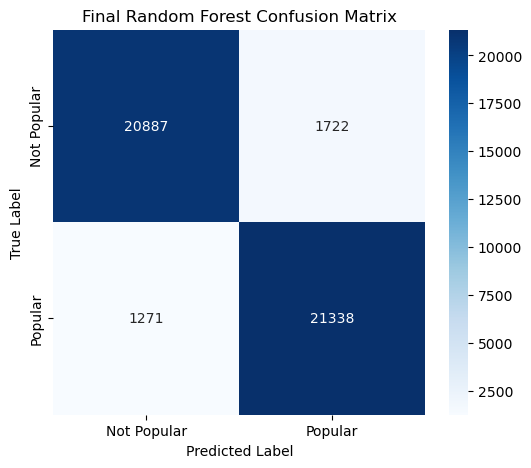

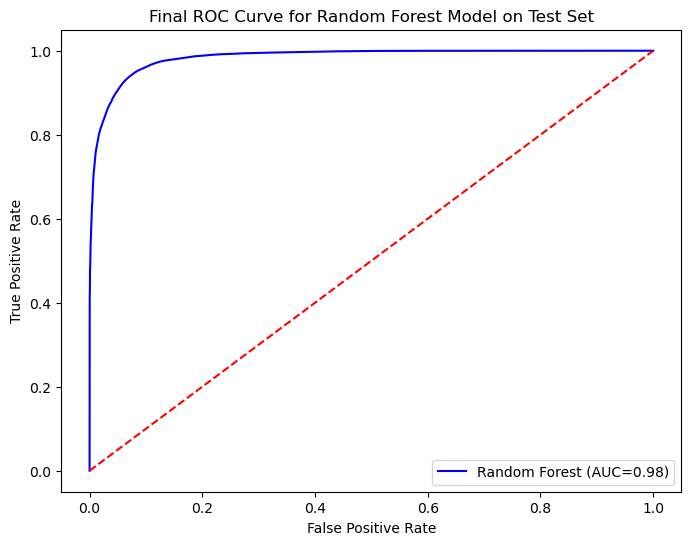

In [30]:
# Re-train the model to ensure consistency
rf_model.fit(X_train, y_train)

# Ensure Test Data Matches Train Data
X_test = X_test.astype(X_train.dtypes)  # Fix data type mismatch
X_test = X_test.reset_index(drop=True)  # Fix index mismatches

# Final Predictions on Test Set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# erformance Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Random Forest Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Popular', 'Popular'],
            yticklabels=['Not Popular', 'Popular'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Random Forest Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# ROC Curve Visualization
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curve for Random Forest Model on Test Set")
plt.legend()
plt.show()
